<center>

#*Practico 3: Aplicación de técnicas de aprendizaje automático no supervisado*
###Mentoría: Análisis de Películas
##*- Grupo 1 -*

## Introducción

En este practico vamos a apoyarnos en el aprendizaje no supervisado para analizar nuestro dataset. El objetivo es profundizar la exploración, e intentar descubrir algún patron desconocido dentro de los datos que no hayamos podido ver en los primeros dos prácticos, o confirmar los que si se hayan visto.

## Parte 0 - Selección de features

Los features son las columnas del dataset en la etapa previa al entrenamiento de un modelo de aprendizaje automático. Esta etapa condiciona completamente a las siguientes. Cuando seleccionan un grupo de features de un dataset, lo hacen con una intención clara, y una pregunta para responder. En nuestro caso, queremos profundizar la exploración, buscando relaciones entre features que hayamos destacado o vimos interesantes en los prácticos anteriores. Cuando piensen en la relación que quieran explorar, compongan las features que crean que afectan a esa relación para ahi encontrar los clusters. Tienen que apoyarse en los análisis realizados para justificar la selección.

### Consigna

- Hagan 1 o mas selecciones de columnas para entrenar en un modelo no supervisado. Puede haber categóricas y/o numéricas.
- Justifiquen la selección de columnas. Que enfoque quieren dar a la exploración?

## Parte I - Limpieza de datos

Es importante la limpieza de datos previa a entrenar el modelo. El análisis y la curación realizadas en prácticos anteriores es esencial para comprender el comportamiento del modelo. Si hay muchos outliers o datos erróneos, el modelo no va a funcionar como queremos que lo haga.

Necesariamente, los features son arrays de colecciones numéricas (matrices o tensores). Esto significa que debemos codificar todas nuestras variables categóricas si queremos incluirlas en nuestro modelo.

### Consigna

- Todos los features seleccionados deben estar correctamente curados, filtrados, escalados de ser necesario si son numéricos, y codificados si son categóricos. **Esto implica que la cantidad total de filas del dataset resultante sera afectado por los filtros de cada feature seleccionado.** Reutilizar los filtros descritos en el practico anterior.

## Parte II - PCA

PCA es *principal component analysis*, y como lo dice el nombre, analiza los componentes principales de un conjunto de datos. Se torna útil cuando tenemos muchas columnas, y en nuestro caso posiblemente sea el caso cuando incluyamos las features categóricas con encoding.

### Consignas

- Apliquen escalado de 0 a 1 a las columnas numéricas
- Codifiquen las columnas categóricas
- Apliquen PCA sobre los features resultantes. Estudien y visualicen los resultados. **Describan lo que ven.** Recuerden que la salida del PCA pierde interpretabilidad en los features, lo cual dificulta el análisis, pero tienen que enfocarse en la visualización e intentar deducir el comportamiento.

## Parte III - Aplicación de modelos no supervisados.

Vamos a hacer unos análisis básicos con Kmeans y HDBSCAN y luego abrimos a investigar modelos que se adapten mejor al enfoque.

### Consignas

- Seleccionar un conjunto de features y aplicar:
    - Kmeans
    - HDBSCAN
    - (opcional) AgglomerativeClustering
- En todos los modelos que prueben, hagan dos o tres iteraciones, cambiando configuraciones de hiperparametros que produzcan resultados interesantes. **Analicen y describan los resultados. Incluyan en el análisis a los hiperparametros conocidos**
- Análisis de los resultados:
    - Que resultados tuvieron? son buenos o malos? porque? Reflejan o no la realidad bajo algún punto de vista?
    - Observen los hiperparametros. Cuales afectan mas en los resultados?
- Repitan el análisis para otra selección de features (puede ser la misma selección pero [con o sin PCA](https://www.notion.so/Consignas-Practico-3-e4890c44e91346929d309d74cdb1a7fb?pvs=21))
- Investiguen 1 o 2 modelos mas en internet, incluso pueden ver otros modelos que hayan sido usados en este mismo dataset (ver sitio en kaggle), también para encontrar clusters. Cuales modelos se acomodan mejor a este set de datos? La respuesta a esa pregunta va a depender de los features seleccionados.
    - Elijan uno o dos modelos y apliquenlos al dataset. Justifiquen la elección.
    - Visualicen los resultados. Describan lo que ven.

---

---

### Anexo I - Nota sobre PCA

No es necesario que usen siempre el PCA para reducir el dataset. Por lo general se considera por la ultilidad en datasets con muchas columnas, pero tiene asociado el costo de perder la interpretabilidad de los resultados. Se puede, de todas maneras, aplicar el transformador inverso al resultado del modelo no supervisado para volver a obtener las variables originales y visualizar en que clusters quedaron.

Lo mejor es probar la mayor cantidad de combinaciones posibles, sobre todo si los resultados no son buenos o son muy difíciles de interpretar. Usar PCA, no usarlo, usarlo pero invertirlo después, etcetera. En el informe pueden dejar solo las relevantes o las que se considere que da resultados mas interpretables y valiosos. Como siempre, **describan lo que ven.** Esta es la parte donde es mas valioso ser descriptivo, y cobra mucha importancia el análisis exploratorio para entender lo que pasa.

# Respuestas
## Carga de paquetes y base de datos

In [ ]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.cluster import KMeans
from ast import literal_eval

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('https://raw.githubusercontent.com/Mentoria-DiploDatos-2023-FaMAFyC/movies-database/main/movies_metadata.csv')

for col in ['genres',
            'production_companies',
            'production_countries',
            'spoken_languages']:

    # Accede a todos los dicts de cada lista y guarda el campo 'name' en la lista a retornar
    df[col] = df[col].fillna('[]').apply(literal_eval).apply(
        lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Extrae el campo 'name' de cada dict en la columna
df['belongs_to_collection'] = df['belongs_to_collection'].fillna(
    'None').apply(literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Agregar variable score basada en IMDB

C= df['vote_average'].mean() # promedio de votos
m= df['vote_count'].quantile(0.9) # usamos el valor del percentil 90 para determinar el piso de votos requeridos para ser considerado

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

df['score'] = df.apply(weighted_rating, axis=1)

df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'score'],
      dtype='object')

In [ ]:
#sns.set_palette('YlOrBr_r', n_colors=10)

custom_palette = ['#ae2012', '#0a9396', '#ee9b00', '#e9d8a6', '#94d2bd', '#ca6702', '#003846']
# Set the custom color palette using

sns.set_palette(custom_palette)

sns.color_palette(palette=custom_palette)

[(0.6823529411764706, 0.12549019607843137, 0.07058823529411765),
 (0.0392156862745098, 0.5764705882352941, 0.5882352941176471),
 (0.9333333333333333, 0.6078431372549019, 0.0),
 (0.9137254901960784, 0.8470588235294118, 0.6509803921568628),
 (0.5803921568627451, 0.8235294117647058, 0.7411764705882353),
 (0.792156862745098, 0.403921568627451, 0.00784313725490196),
 (0.0, 0.2196078431372549, 0.27450980392156865)]

## Parte 0

Las siguientes variables se eliminan del data frame por no tratarse de variables relevantes para los algoritmos de aprendizaje no supervisado: 'belongs_to_collection', 'homepage', 'id', 'imdb_id', 'original_title', 'overview', 'status', 'tagline', 'title', 'video', 'poster_path'. La variable 'production_companies' se la elimina porque cuenta con muy pocos datos.

In [ ]:
to_drop = ['belongs_to_collection', 'homepage', 'imdb_id','id', 'original_title', 'overview', 'status', 'tagline', 'title', 'video', 'poster_path','production_companies']
df.drop(columns=to_drop, inplace=True)
df.columns

Index(['adult', 'budget', 'genres', 'original_language', 'popularity',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'vote_average', 'vote_count', 'score'],
      dtype='object')

## Parte I

Ahora aplicamos los filtros definidos en el práctico anterior. Los mismos son los siguientes: para runtime filtramos > 60 minutos (definición de largometraje), y para vote_count los casos donde vote_count == 0. Además, escalamos las variables numéricas.

In [ ]:
# Aplicamos el filtro al dataset de runtime
cond_runtime = df['runtime']>=60
df_filtered = df[cond_runtime]

# Aplicamos el filtro para vote_count:
df_filtered = df_filtered[df_filtered['vote_count'] != 0]

#Escalamos variables numéricas:
var_num = ['budget','popularity','revenue','runtime','score','vote_count','vote_average']
var_cat = ['adult','genres','original_language','production_countries','release_date','spoken_languages']

data_to_scale = df_filtered[var_num]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

df_num = pd.DataFrame(scaled_data, columns=var_num)
df_num = df_num.reset_index()
df_num

index    budget  popularity   revenue   runtime     score  vote_count  \
0          0  0.078947    0.040087  0.133988  0.017559  0.834268    0.384681   
1          1  0.171053    0.031079  0.094261  0.036789  0.665586    0.171380   
2          2  0.000000    0.021394  0.000000  0.034281  0.484519    0.006466   
3          3  0.042105    0.007049  0.029216  0.056020  0.435663    0.002345   
4          4  0.000000    0.015320  0.027468  0.038462  0.427034    0.012221   
...      ...       ...         ...       ...       ...       ...         ...   
39105  39105  0.000000    0.001208  0.000000  0.020903  0.415586    0.000000   
39106  39106  0.000000    0.010382  0.000000  0.036789  0.420644    0.001776   
39107  39107  0.000000    0.000132  0.000000  0.025084  0.416225    0.000000   
39108  39108  0.000000    0.000326  0.000000  0.250836  0.431097    0.000142   
39109  39109  0.000000    0.001649  0.000000  0.025084  0.404773    0.000355   

       vote_average  
0              0.77  
1              0.69  
2              0.65  
3              0.61  
4              0.57  
...             ...  
39105          0.35  
39106          0.57  
39107          0.40  
39108          0.90  
39109          0.38  

[39110 rows x 8 columns]

A continuación reagrupamos las variables numéricas escaladas con las categóricas

In [ ]:
df_cat = df_filtered[var_cat]
df_cat = df_cat.reset_index()
len(df_num), len(df_cat), len(df_filtered)

(39110, 39110, 39110)

In [ ]:
df_rejoined = pd.concat([df_num, df_cat], axis=1)
df_rejoined.drop('index', axis=1, inplace=True)
df_rejoined.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'score', 'vote_count',
       'vote_average', 'adult', 'genres', 'original_language',
       'production_countries', 'release_date', 'spoken_languages'],
      dtype='object')

Ahora pasamos a codificar las variables categóricas. Los criterios son los siguientes:

- adult: la codificamos como True = 1 y False = 0 (dummy)
- genres: one-hot-encoding
- original language: si es en inglés = 1 y 0 en caso contrario
- production_countries: si es una productora estadounidense = 1, 0 caso contrario
- release_date: = 1 si es una película moderna (desde los 2000), 0 en caso contrario
- spoken_languages: = 1 si es en inglés, 0 caso contrario.


In [ ]:
# adult

df_rejoined['adult'] = df_rejoined['adult'].map({'True': 1, 'False': 0})
df_rejoined['adult'].unique()

array([0, 1])

In [ ]:
# genres

df_rejoined = df_rejoined.join(pd.crosstab((s:=df_rejoined['genres'].explode()).index, s))
df_rejoined.columns
genres = ['Action','Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']

In [ ]:
# original_language

df_rejoined['original_language'].unique()

array(['en', 'fr', 'zh', 'it', 'fa', 'nl', 'de', 'cn', 'ar', 'es', 'ru',
       'sv', 'ja', 'ko', 'sr', 'bn', 'pt', 'wo', 'ro', 'hu', 'cy', 'vi',
       'cs', 'da', 'no', 'nb', 'pl', 'el', 'sh', 'xx', 'mk', 'bo', 'ca',
       'fi', 'th', 'sk', 'bs', 'he', 'hi', 'tr', 'is', 'ps', 'ab', 'eo',
       'ka', 'mn', 'bm', 'zu', 'uk', 'af', 'la', 'et', 'ku', 'lv', 'ta',
       'sl', 'tl', 'ur', 'rw', 'id', 'bg', 'mr', 'lt', 'kk', 'ms', 'sq',
       'qu', 'te', 'am', 'jv', 'tg', nan, 'ml', 'hr', 'lo', 'ay', 'kn',
       'ne', 'pa', 'gl', 'ky', 'sm', 'eu', 'hy', 'iu', 'si'], dtype=object)

In [ ]:
df_rejoined['original_language'] = df['original_language'].apply(lambda x: 1 if x == 'en' else 0)
df_rejoined['original_language'].unique()

array([1, 0])

In [ ]:
# production_countries

df_rejoined['production_countries']
df_rejoined['production_countries'] = df_rejoined['production_countries'].apply(lambda x: 1 if 'United States of America' in x else 0)
df_rejoined['production_countries'].unique()

array([1, 0])

In [ ]:
# 'release_date'

df_rejoined['release_date'] = pd.to_datetime(df_rejoined['release_date'], errors='coerce')
df_rejoined['year'] = df_rejoined['release_date'].dt.year
df_rejoined['modern_film'] = df_rejoined['year'].apply(lambda x: 1 if x >= 2000 else 0)
df_rejoined['modern_film'].unique()

array([0, 1])

In [ ]:
# 'spoken_languages'

df_rejoined['spoken_languages']
df_rejoined['spoken_languages'] = df_rejoined['spoken_languages'].apply(lambda x: 1 if 'English' in x else 0)
df_rejoined['spoken_languages'].unique()

array([1, 0])

In [ ]:
to_drop2 = ['genres', 'release_date','year','vote_average','vote_count'] # saco vote_average y vote_count porque ya las capta score
df_rejoined.drop(columns=to_drop2, inplace=True)
df_rejoined.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'score', 'adult',
       'original_language', 'production_countries', 'spoken_languages',
       'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
       'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War',
       'Western', 'modern_film'],
      dtype='object')

Ahora ya tenemos el data frame con todos los filtros aplicados, todas las variables numéricas escaladas, y todas las variables categóricas codificadas. Decidimos eliminar las filas con NAs porque son sólo 1122 casos

In [ ]:
len(df_rejoined) - len(df_rejoined.dropna())

1122

In [ ]:
df = df_rejoined.dropna()
print(df)

         budget  popularity   revenue   runtime     score  adult  \
0      0.078947    0.040087  0.133988  0.017559  0.834268      0   
1      0.171053    0.031079  0.094261  0.036789  0.665586      0   
2      0.000000    0.021394  0.000000  0.034281  0.484519      0   
3      0.042105    0.007049  0.029216  0.056020  0.435663      0   
4      0.000000    0.015320  0.027468  0.038462  0.427034      0   
...         ...         ...       ...       ...       ...    ...   
39105  0.000000    0.001208  0.000000  0.020903  0.415586      0   
39106  0.000000    0.010382  0.000000  0.036789  0.420644      0   
39107  0.000000    0.000132  0.000000  0.025084  0.416225      0   
39108  0.000000    0.000326  0.000000  0.250836  0.431097      0   
39109  0.000000    0.001649  0.000000  0.025084  0.404773      0   

       original_language  production_countries  spoken_languages  Action  ...  \
0                      1                     1                 1     0.0  ...   
1                    

## Parte II

Creamos un data frame que contenga sólo las variables numéricas para poder aplicarle un PCA

In [ ]:
var_num = ['budget','popularity','revenue','runtime','score']
df_num = df[var_num]
df_num.head()

budget  popularity   revenue   runtime     score
0  0.078947    0.040087  0.133988  0.017559  0.834268
1  0.171053    0.031079  0.094261  0.036789  0.665586
2  0.000000    0.021394  0.000000  0.034281  0.484519
3  0.042105    0.007049  0.029216  0.056020  0.435663
4  0.000000    0.015320  0.027468  0.038462  0.427034

Las variables deben estar escaladas porque el análisis de componentes principales se basa en la covarianza entre las variables y si las variables originales están en diferentes escalas, la covarianza entre ellas se ve afectada, y puede llevar a que las variables con unidades más grandes dominen la variabilidad en el análisis y sesguen los resultados. Esto ya fue resuelto en los pasos de preparación del Data Frame por lo que sería redundante repetirlo ahora.
Para ver qué número de componentes principales sería mejor usar, armamos un for loop para que realice el PCA con distinto número de componentes y que vaya guardando la varianza explicada por cada uno en una lista  que luego printeamos para poder tomar una decisión.

In [ ]:
from sklearn.decomposition import PCA

explained_variances = []

# armo el loop para hacer el PCA con distintos numeros de componentes
for n_components in range(5, 1, -1):
    pca = PCA(n_components=n_components)
    pca.fit(df_num)
    explained_variance_ratio = pca.explained_variance_ratio_
    total_variance_retained = sum(explained_variance_ratio)
    explained_variances.append((n_components, total_variance_retained))

# convierto la lista a un df
explained_variance_df = pd.DataFrame(explained_variances, columns=['n componentes', 'total de varianza retenida'])

# printeo
print(explained_variance_df)

   n componentes  total de varianza retenida
0              5                    1.000000
1              4                    0.989415
2              3                    0.964497
3              2                    0.892958


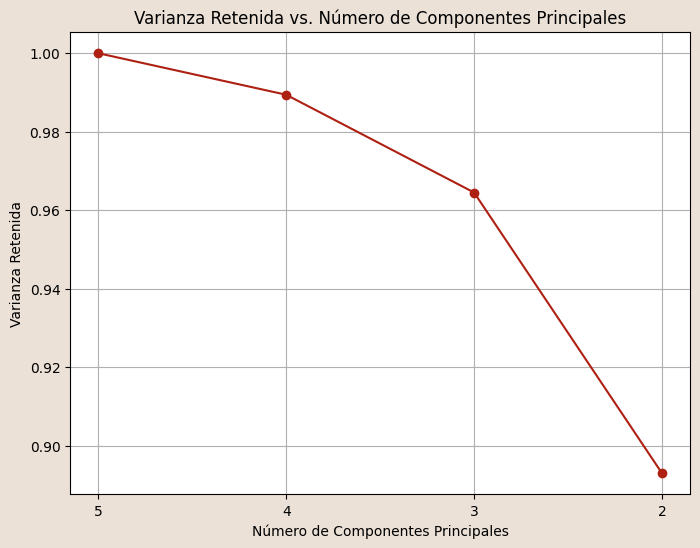

In [ ]:
# Obtener los datos de varianza retenida del DataFrame explained_variance_df
n_componentes = explained_variance_df['n componentes']
varianza_retenida = explained_variance_df['total de varianza retenida']

plt.figure(figsize=(8, 6), facecolor='#EBE1D7')
plt.plot(n_componentes, varianza_retenida, marker='o', linestyle='-')
plt.title('Varianza Retenida vs. Número de Componentes Principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Retenida')
plt.grid(True)
plt.xticks(n_componentes)
plt.gca().invert_xaxis()  # Invertir el eje x para mostrar desde el mayor al menor número de componentes
plt.show()

   n componentes  total de varianza retenida
0              5                    1.000000
1              4                    0.989415
2              3                    0.964497
3              2                    0.892958
Componentes Principales para n_components = 5:
     budget  popularity   revenue   runtime     score
0  0.398409    0.082415  0.210895  0.074930  0.885656
1  0.836292    0.050943  0.303946  0.001769 -0.453469
2 -0.014807   -0.017218 -0.055775  0.996211 -0.062740
3 -0.376384    0.197557  0.901561  0.044046 -0.067478
4 -0.001369    0.975340 -0.217293  0.002241 -0.038591


Componentes Principales para n_components = 4:
     budget  popularity   revenue   runtime     score
0  0.398409    0.082415  0.210895  0.074930  0.885656
1  0.836292    0.050943  0.303946  0.001769 -0.453469
2 -0.014807   -0.017218 -0.055775  0.996211 -0.062740
3 -0.376384    0.197557  0.901561  0.044046 -0.067478


Componentes Principales para n_components = 3:
     budget  popularity   revenue   

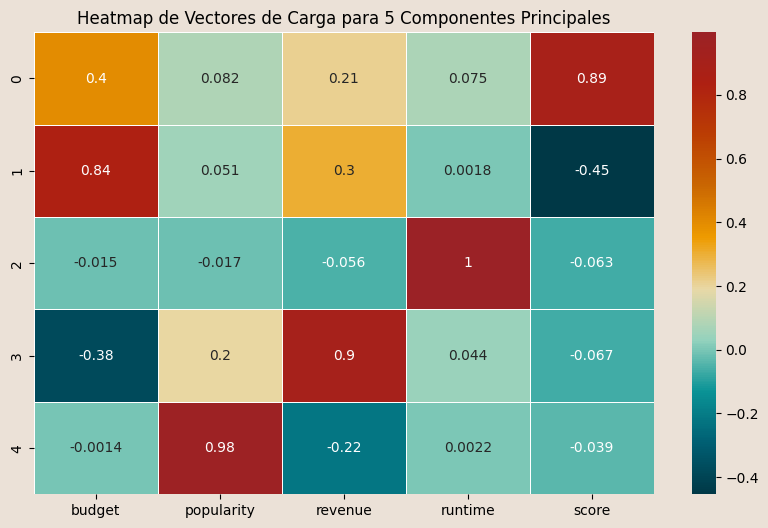

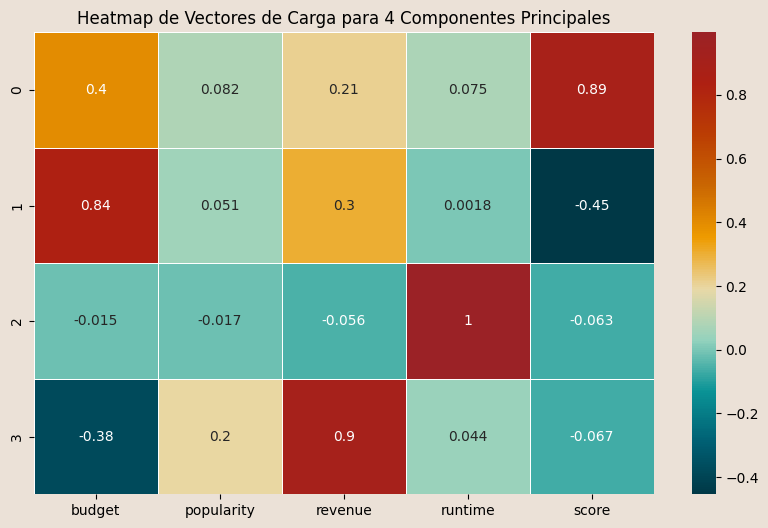

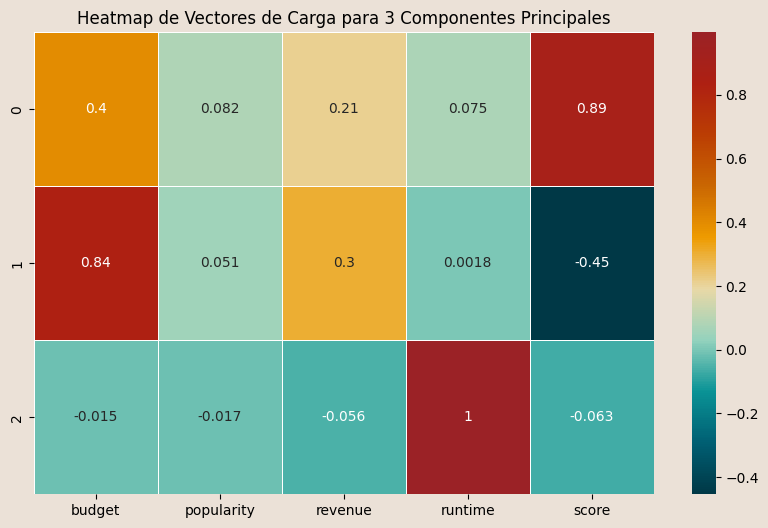

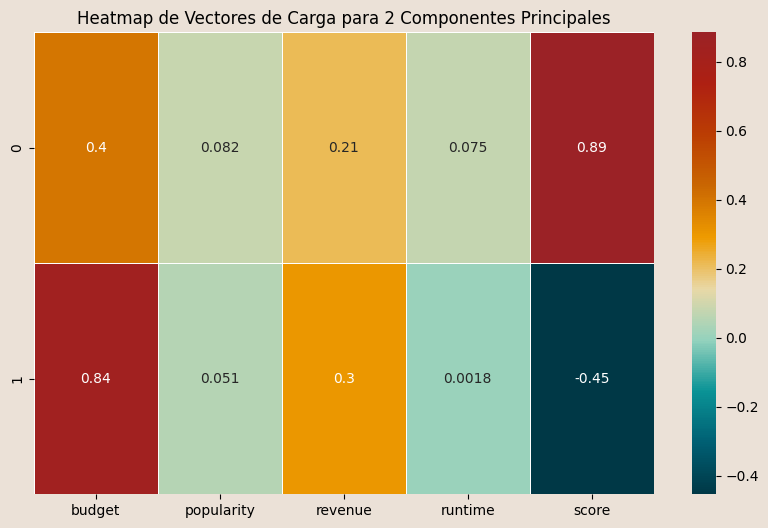

In [ ]:
explained_variances = []

# Inicializa un DataFrame para almacenar los vectores de carga
loadings_df_list = []

# armo el loop para hacer el PCA con distintos numeros de componentes
for n_components in range(5, 1, -1):
    pca = PCA(n_components=n_components)
    pca.fit(df_num)
    explained_variance_ratio = pca.explained_variance_ratio_
    total_variance_retained = sum(explained_variance_ratio)
    explained_variances.append((n_components, total_variance_retained))

    # Obtén los vectores de carga y almacénalos en un DataFrame
    loadings_df = pd.DataFrame(pca.components_, columns=df_num.columns)
    loadings_df_list.append((n_components, loadings_df))

# convierto la lista a un df
explained_variance_df = pd.DataFrame(explained_variances, columns=['n componentes', 'total de varianza retenida'])

# printeo
print(explained_variance_df)

# Imprime los vectores de carga para cada n_components
for n_components, loadings_df in loadings_df_list:
    print(f"Componentes Principales para n_components = {n_components}:")
    print(loadings_df)
    print("\n")

custom_palette2 = [ '#9b2226', '#ae2012', '#bb3e03', '#ca6702', '#ee9b00', '#e9d8a6', '#94d2bd', '#0a9396', '#005f73', '#003846']

# Invertir la paleta de colores personalizada
custom_palette2 = custom_palette2[::-1]
#sns.set_palette(custom_palette2)

# Crear un objeto cmap a partir de la paleta personalizada
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('custom_colormap', custom_palette2)

# Loop para calcular y visualizar los vectores de carga
for n_components, loadings_df in loadings_df_list:
    plt.figure(figsize=(10, 6), facecolor='#EBE1D7')
    plt.title(f"Heatmap de Vectores de Carga para {n_components} Componentes Principales")
    sns.heatmap(loadings_df, annot=True, cmap=cmap, linewidths=.5)
    plt.show()


Con 3 componentes principales se retiene más del 95% de la varianza explicada, y con 5 el 99%.

In [ ]:
n_components = 5
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df_num)

Para las estimaciones posteriores con algoritmos de Aprendizaje No Supervisado nos vamos a quedar con las 3 features que capturan la varianza en mayor medida.

In [ ]:
selected_features = principal_components[:, :3]
selected_features

array([[ 0.4011003 , -0.0813695 , -0.05060962],
       [ 0.28072142,  0.05965015, -0.0198616 ],
       [ 0.03134392, -0.03043967, -0.00304342],
       ...,
       [-0.03158265, -0.00056983, -0.00755507],
       [-0.00147939, -0.00690463,  0.21640575],
       [-0.04160003,  0.00470057, -0.00686271]])

## Parte III



### K-Means


#### Con todas las variables

In [ ]:
wcss = []
for i in range(1, 11):  # Trying clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

print(wcss)

[99050.6774871136, 85881.34434500674, 79385.58871786452, 74766.4954631823, 72035.10323048591, 69109.0091003273, 66492.99463749438, 64118.85019544198, 62737.3237870524, 60793.24138956414]


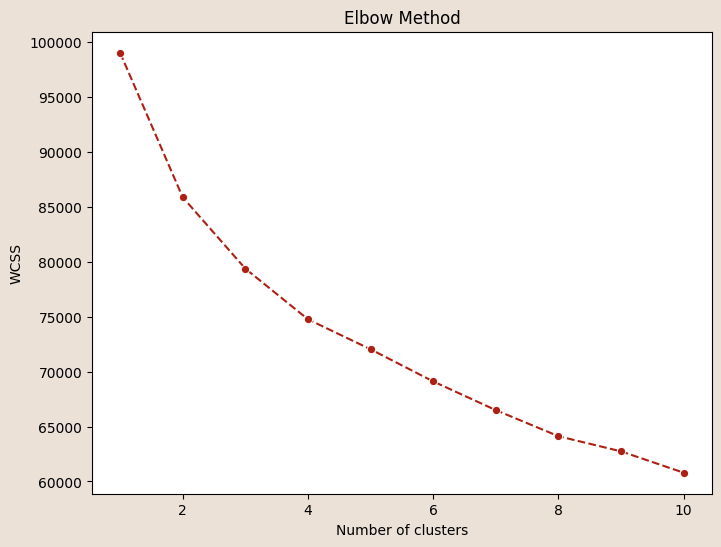

In [ ]:
# Plotting the Elbow graph
plt.figure(figsize=(8, 6), facecolor='#EBE1D7')
sns.lineplot(x=range(1, 11), y=wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

Pareciera que se debieran optar 2, 3 o 4 clusters. Probamos con 4, para mayor diversidad.

In [ ]:
n_clust = 4
km = KMeans(n_clusters=n_clust, init = 'k-means++', random_state = 42)
km.fit(df)

# Etiquetas asignadas por el algoritmo
clusters = km.labels_

Cluster 0: 9599 individuals
Cluster 1: 8789 individuals
Cluster 2: 11552 individuals
Cluster 3: 8048 individuals


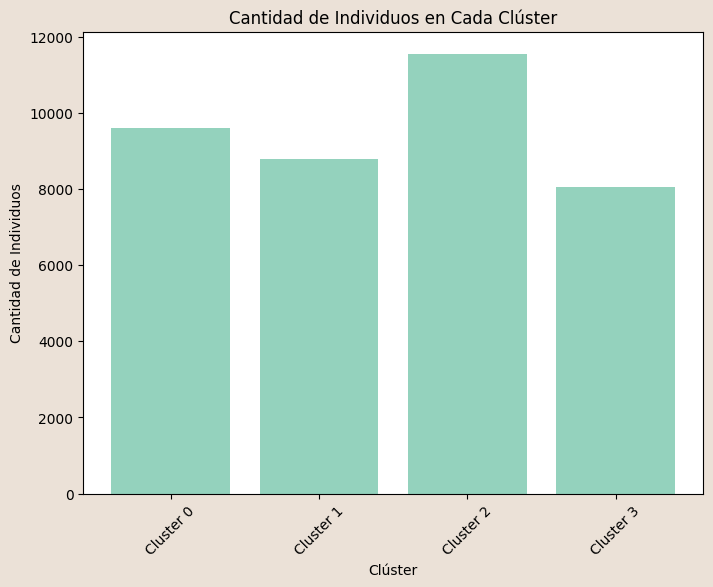

In [ ]:
# Counting individuals in each cluster
cluster_counts = np.bincount(clusters)

# Print cluster counts
for cluster_num, count in enumerate(cluster_counts):
    print(f'Cluster {cluster_num}: {count} individuals')

# Nombres de los clústeres (puedes cambiarlos según tus necesidades)
cluster_names = [f'Cluster {i}' for i in range(len(cluster_counts))]

# Crea el gráfico de barras
plt.figure(figsize=(8, 6), facecolor='#EBE1D7')
plt.bar(cluster_names, cluster_counts, color='#94d2bd')
plt.xlabel('Clúster')
plt.ylabel('Cantidad de Individuos')
plt.title('Cantidad de Individuos en Cada Clúster')
plt.xticks(rotation=45)  # Rotamos los nombres de los clústeres para que sean legibles
plt.show()


La distribución entre clusters no parece desproporcionada, no hay un cluster que acapare una mayoría.

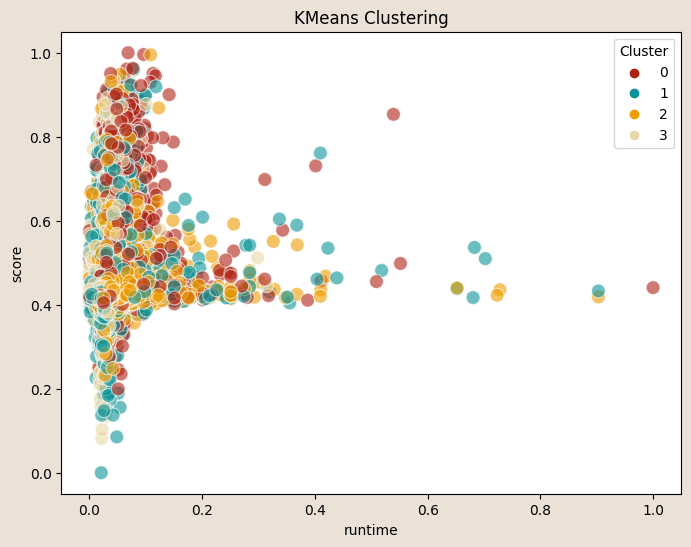

In [ ]:
df_kmeans = df.copy()

df_kmeans['Cluster'] = clusters

# Visualizing the clusters using a scatter plot
# Set the color palette for the clusters (adjust the number of colors based on the number of clusters)
#colors = sns.color_palette('husl', n_clust)

# Plotting using Seaborn
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_kmeans, x='runtime', y='score', hue='Cluster', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('runtime')
plt.ylabel('score')
plt.title('KMeans Clustering')
plt.legend(title='Cluster')
plt.show()

No parece que la segrtegación entre clusters se haya hecho usando estas 2 variables. probamos 2 más.

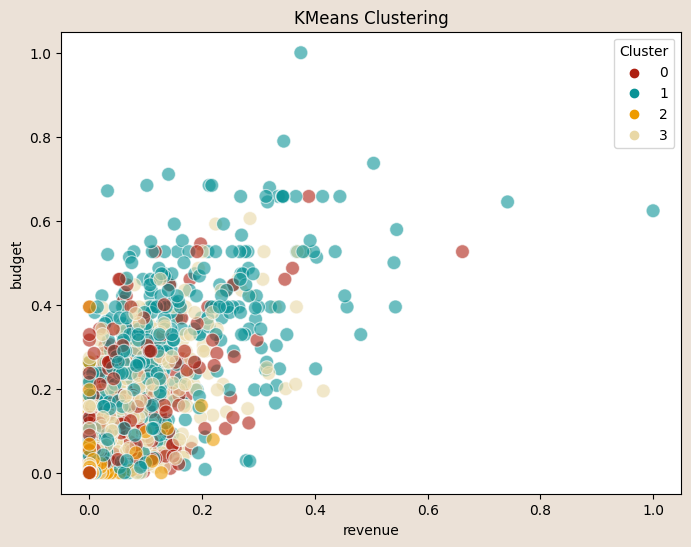

In [ ]:
df_kmeans = df.copy()

df_kmeans['Cluster'] = clusters

# Visualizing the clusters using a scatter plot
# Set the color palette for the clusters (adjust the number of colors based on the number of clusters)
#colors = sns.color_palette('husl', n_clust)

# Plotting using Seaborn
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_kmeans, x='revenue', y='budget', hue='Cluster', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('revenue')
plt.ylabel('budget')
plt.title('KMeans Clustering')
plt.legend(title='Cluster')
plt.show()

Con estas tampoco, probamos en 3D:

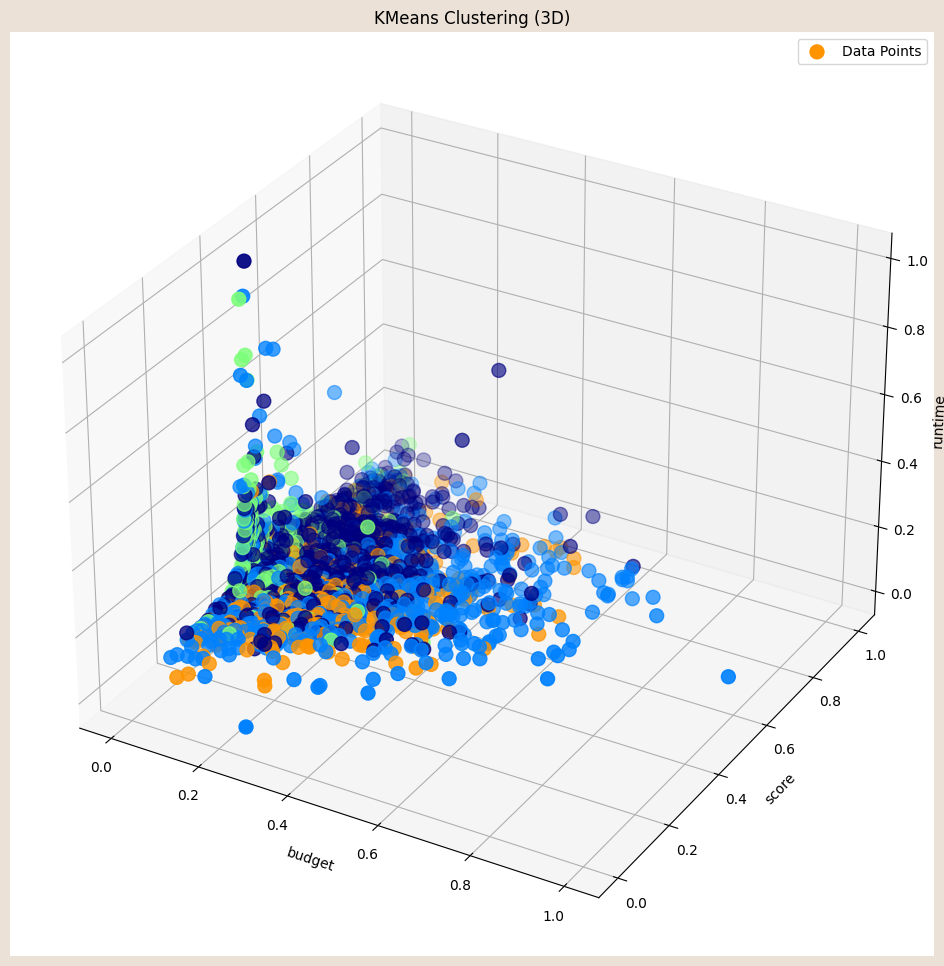

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting tools

colors = plt.cm.jet(clusters.astype(float) / n_clust)  # Using jet colormap

# Creating a 3D scatter plot
fig = plt.figure(figsize=(15, 12),facecolor='#EBE1D7')
ax = fig.add_subplot(111, projection='3d')

# Plotting the data points
ax.scatter(df_kmeans['budget'], df_kmeans['score'], df_kmeans['runtime'], c=colors, s=100, marker='o', label='Data Points')

ax.set_xlabel('budget')
ax.set_ylabel('score')
ax.set_zlabel('runtime')
ax.set_title('KMeans Clustering (3D)')
ax.legend()
plt.show()

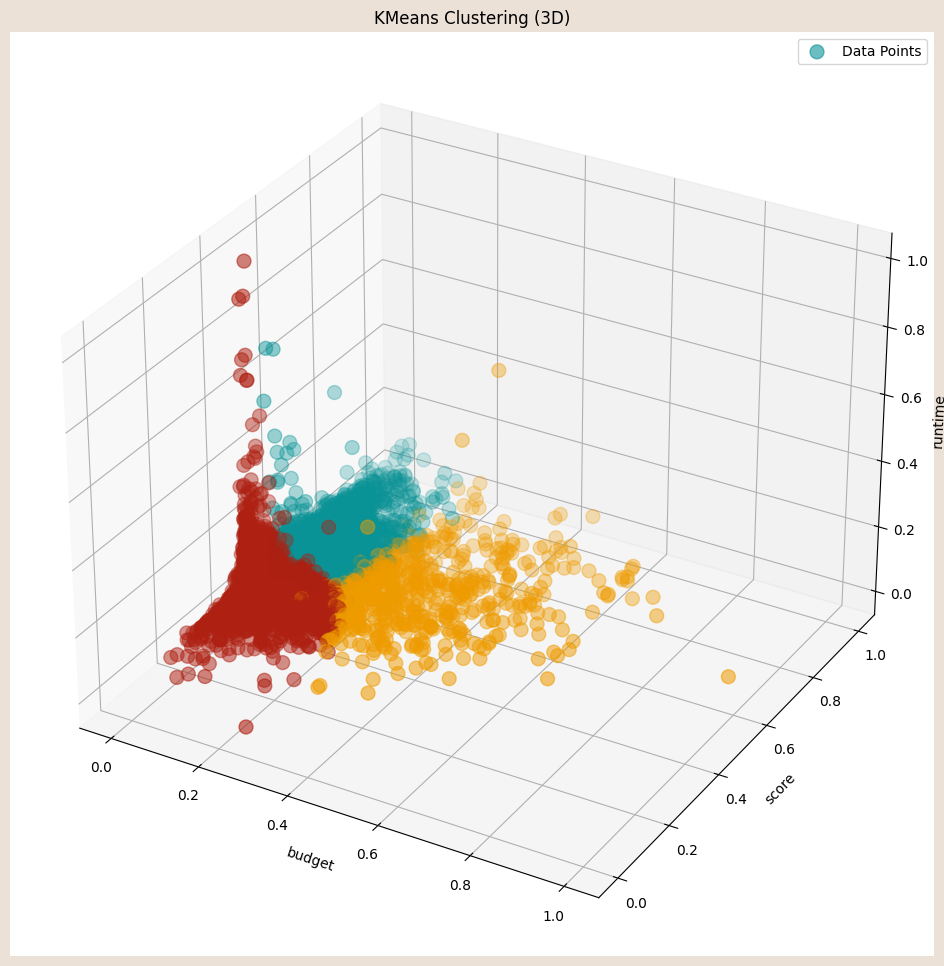

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df_kmeans' with a 'Cluster' column
# and a custom palette 'custom_palette'

# Create a custom color map based on your custom palette
cmap = plt.cm.colors.ListedColormap(custom_palette)

# Creating a 3D scatter plot
fig = plt.figure(figsize=(15, 12), facecolor='#EBE1D7')
ax = fig.add_subplot(111, projection='3d')

# Set the alpha (transparency) value for each data point
alpha = 0.6  # You can adjust this value as needed

# Map cluster values to colors using your custom color map with alpha
colors = [plt.cm.colors.to_rgba(custom_palette[i], alpha=alpha) for i in clusters]

# Plotting the data points with custom colors and alpha
sc = ax.scatter(df_kmeans['budget'], df_kmeans['score'], df_kmeans['runtime'], c=colors, s=100, marker='o', label='Data Points', cmap=cmap)

ax.set_xlabel('budget')
ax.set_ylabel('score')
ax.set_zlabel('runtime')
ax.set_title('KMeans Clustering (3D)')
ax.legend()

plt.show()

Claramente las variables numéricas no permiten discernir el criterio usado para segrefar entre clusters, por lo que analizamos los géneros:

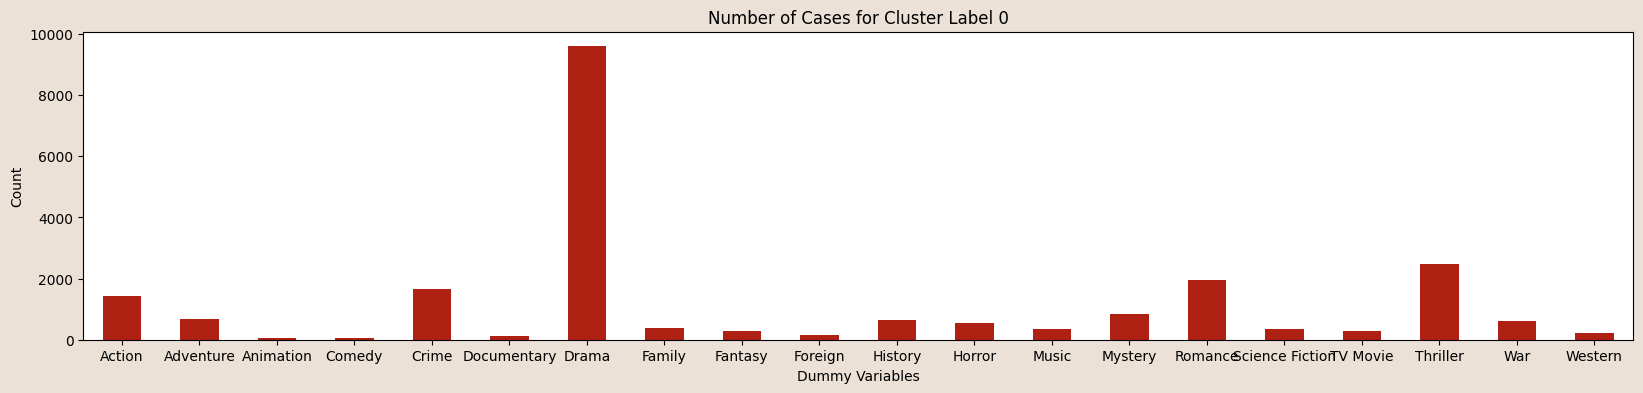

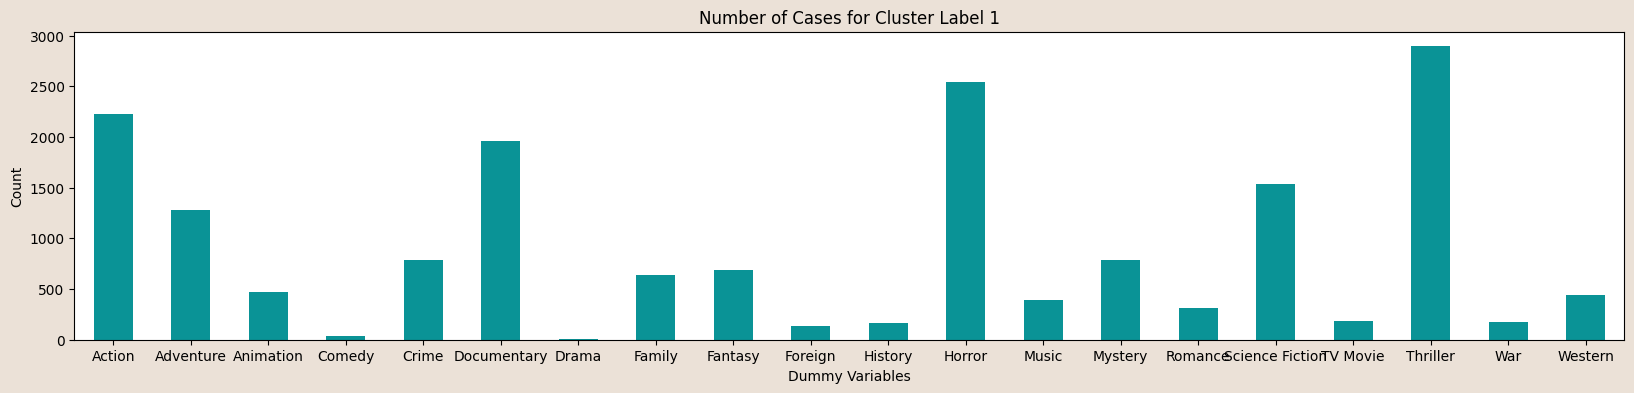

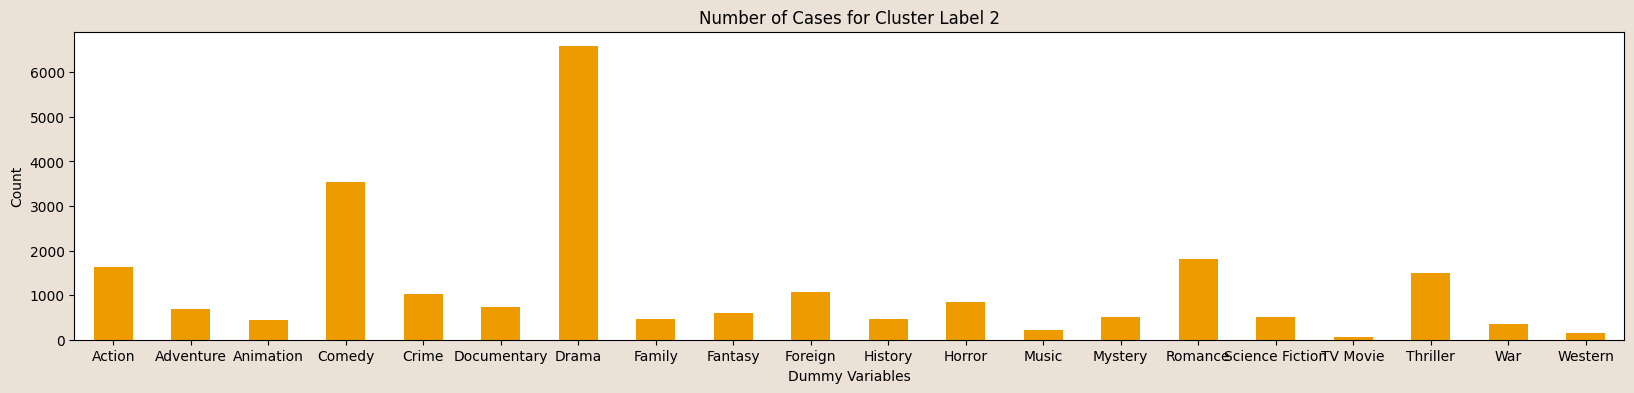

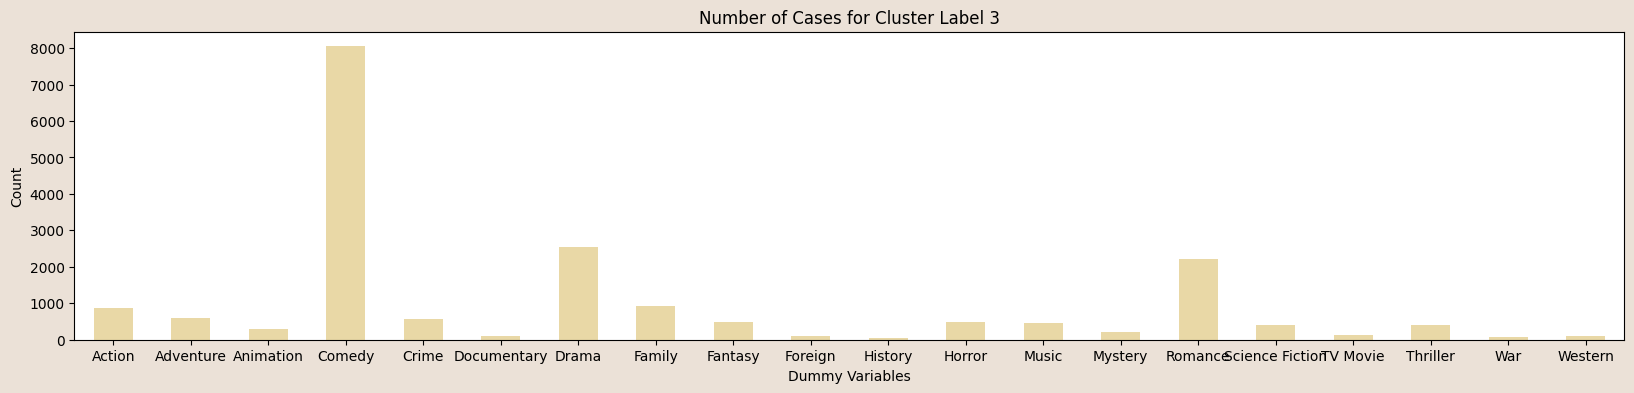

In [ ]:
for cluster_label, color in zip(range(0, 4), custom_palette):
    filtered_df_kmeans = df_kmeans[df_kmeans['Cluster'] == cluster_label]

    # Nos aseguramos que las dummy sean floats
    for var in genres:
        filtered_df_kmeans[var] = pd.to_numeric(filtered_df_kmeans[var])

    # Calculamos el número de casos para cada dummy
    counts = filtered_df_kmeans[genres].sum()

    # Barplot
    plt.figure(figsize=(20, 4), facecolor='#EBE1D7')
    counts.plot(kind='bar', color=color)
    plt.title(f"Number of Cases for Cluster Label {cluster_label}")
    plt.xlabel("Dummy Variables")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()


Centrándonos en los géneros, se observan diferencias relevantes entre los clusters. En el 0 hay una mayoría de películas de drama y un poco de thriller, lo que se contrapone con el cluster 3, que posee una mayoría de películas de comedia y de romance. Por su parte, en el cluster 1 se destacan las películas de thriller y de horror, como también las acción y los documentales. El cluster 2, finalmente, presenta una mayoría de drama, pero esta vez acompañado de películas de comedia.

#### Con las variables numéricas

In [ ]:
wcss = []
for i in range(1, 11):  # Trying clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_num)
    wcss.append(kmeans.inertia_)

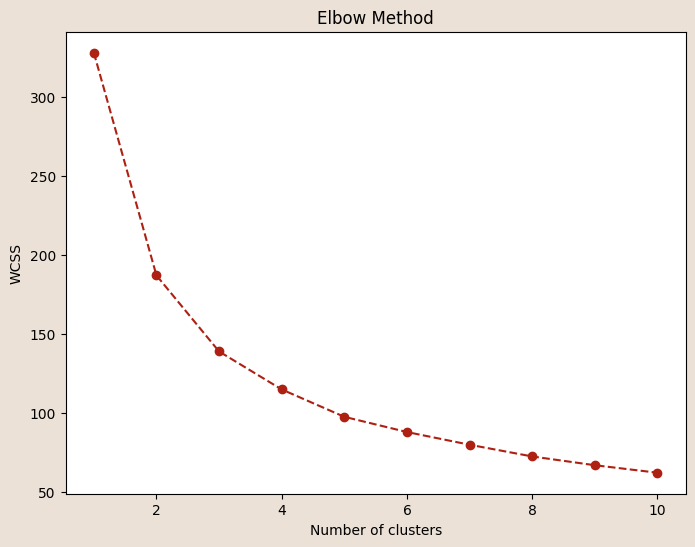

In [ ]:
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

En este caso el quiebre a partir del cual se observa cierta linealidad está más marcado en 2 y 3. Probamos con 3

Cluster 0: 34363 individuals
Cluster 1: 2995 individuals
Cluster 2: 630 individuals


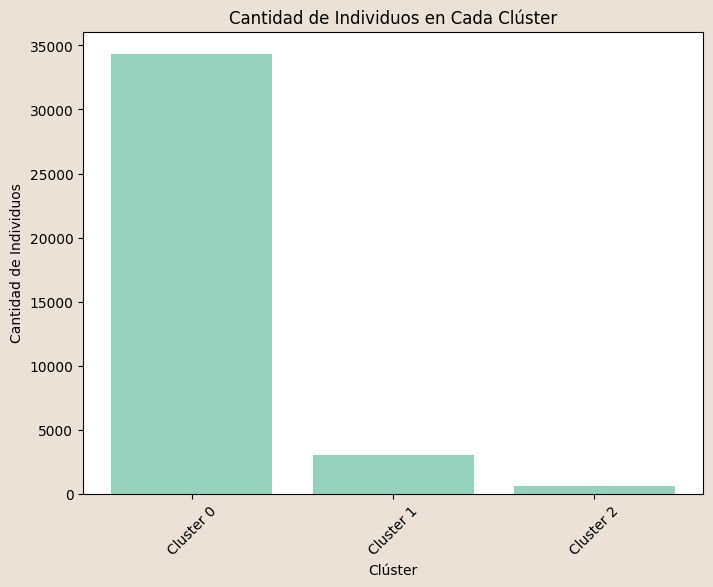

In [ ]:
n_clust = 3
km = KMeans(n_clusters=n_clust, init = 'k-means++', random_state = 42)
km.fit(df_num)

# Etiquetas asignadas por el algoritmo
clusters = km.labels_

# Counting individuals in each cluster
cluster_counts = np.bincount(clusters)

# Print cluster counts
for cluster_num, count in enumerate(cluster_counts):
    print(f'Cluster {cluster_num}: {count} individuals')

# Nombres de los clústeres (puedes cambiarlos según tus necesidades)
cluster_names = [f'Cluster {i}' for i in range(len(cluster_counts))]

# Crea el gráfico de barras
plt.figure(figsize=(8, 6), facecolor='#EBE1D7')
plt.bar(cluster_names, cluster_counts, color='#94d2bd')
plt.xlabel('Clúster')
plt.ylabel('Cantidad de Individuos')
plt.title('Cantidad de Individuos en Cada Clúster')
plt.xticks(rotation=45)  # Rotamos los nombres de los clústeres para que sean legibles
plt.show()

Hay una sobrepoblación en el cluster 0

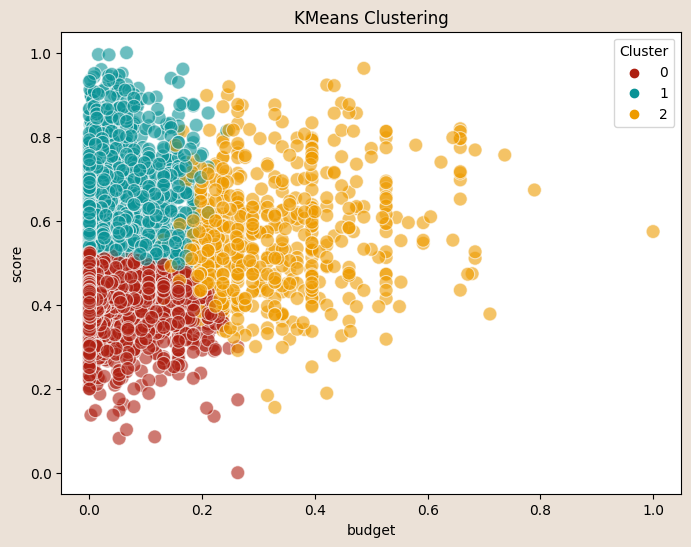

In [ ]:
df_num_kmeans = df_num.copy()

df_num_kmeans['Cluster'] = clusters

# Visualizing the clusters using a scatter plot
# Set the color palette for the clusters (adjust the number of colors based on the number of clusters)
#colors = sns.color_palette('husl', n_clust)

# Plotting using Seaborn
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_num_kmeans, x='budget', y='score', hue='Cluster', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('budget')
plt.ylabel('score')
plt.title('KMeans Clustering')
plt.legend(title='Cluster')
plt.show()

El cluster 0 (el más numeroso) está conformado por películas de bajo presupuesto y de bajo score. El cluster 1 por películas de bajo presupuesto pero alto score. Finalmente está el cluster 2, de películas de alto presupuesto, independientemente del score. Probamos en 3D

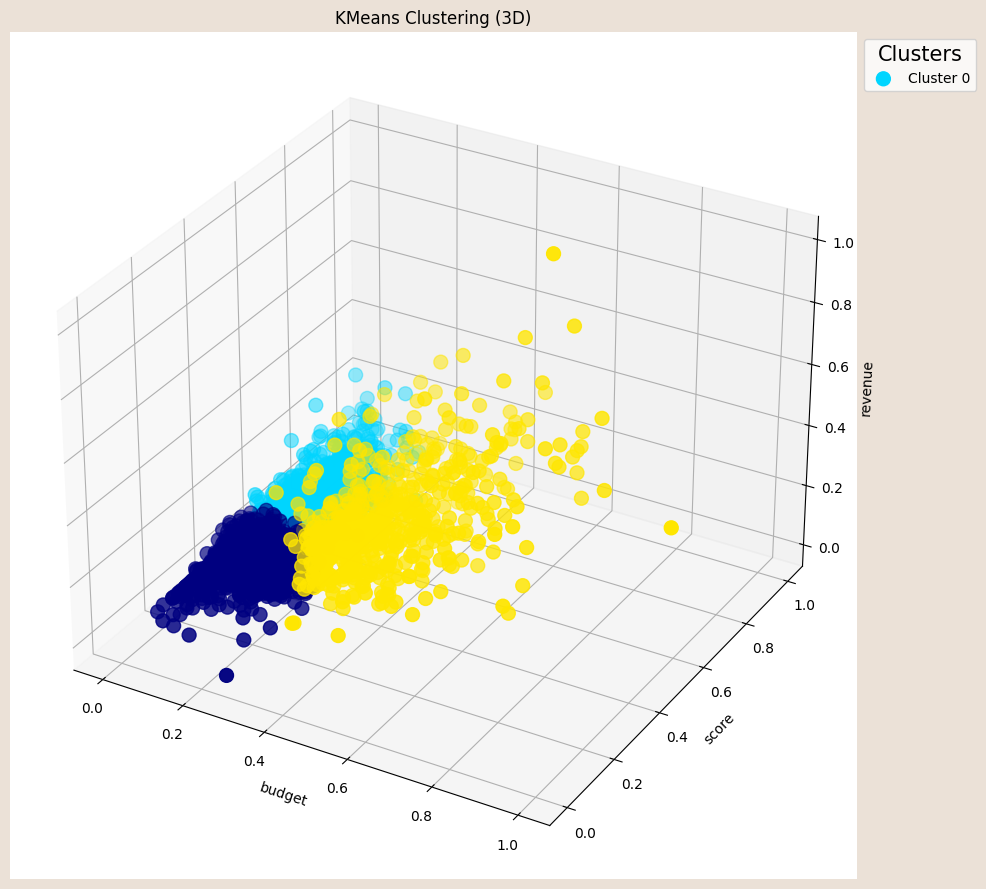

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting tools

colors = plt.cm.jet(clusters.astype(float) / n_clust)  # Using jet colormap

# Creating a 3D scatter plot
fig = plt.figure(figsize=(13, 11),facecolor='#EBE1D7')
ax = fig.add_subplot(111, projection='3d')

# Plotting the data points
scatter = ax.scatter(df_num_kmeans['budget'], df_num_kmeans['score'], df_num_kmeans['revenue'], c=colors, s=100, marker='o', label='Data Points')

ax.set_xlabel('budget')
ax.set_ylabel('score')
ax.set_zlabel('revenue')
ax.set_title('KMeans Clustering (3D)')
ax.legend()

legend_labels = [f'Cluster {i}' for i in range(3)]
legend = plt.legend(handles=[scatter], labels=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
legend.set_title('Clusters', prop={'size': 15})

plt.show()

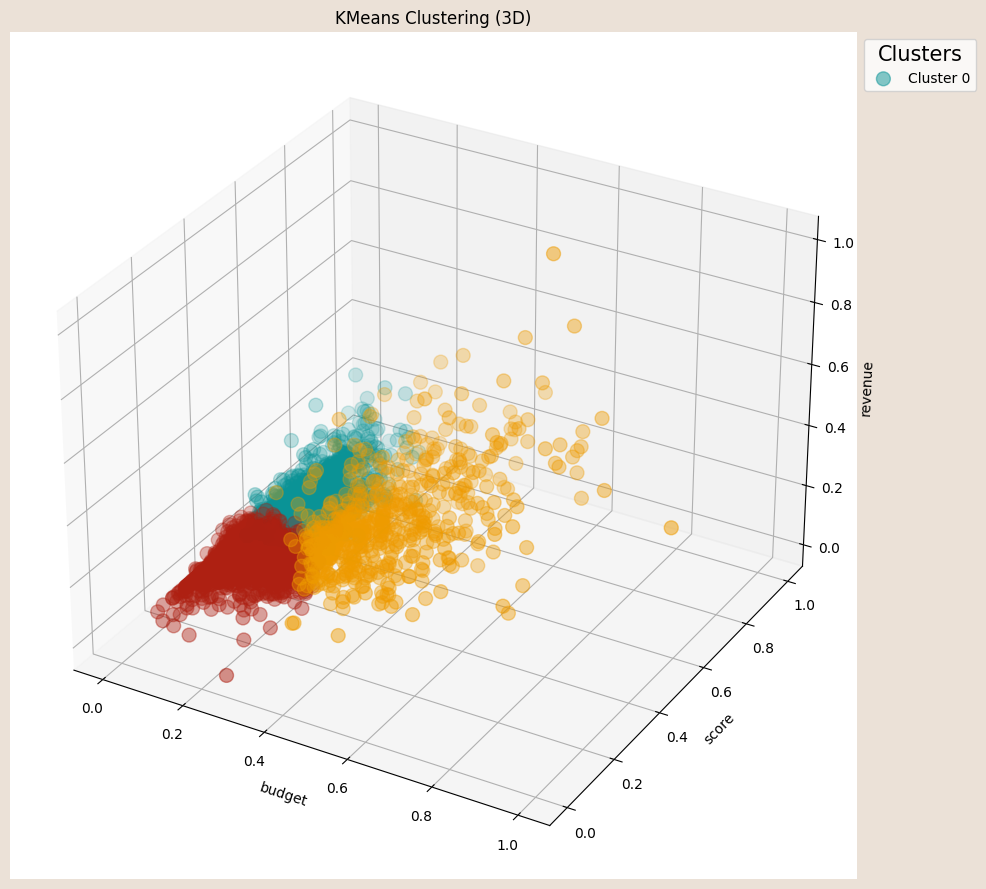

In [ ]:
# custom color map based on custom palette
cmap = plt.cm.colors.ListedColormap(custom_palette)

# Using jet colormap for alpha values
alpha_colors = plt.cm.jet(clusters.astype(float) / n_clust)

# Creating a 3D scatter plot
fig = plt.figure(figsize=(13, 11), facecolor='#EBE1D7')
ax = fig.add_subplot(111, projection='3d')

# Set the alpha (transparency) value for each data point
alpha = 0.5  # You can adjust this value as needed

# Map cluster values to colors using custom color map with alpha
colors = [plt.cm.colors.to_rgba(custom_palette[i], alpha=alpha) for i in clusters]

# Plotting the data points with custom colors and alpha
scatter = ax.scatter(df_kmeans['budget'], df_kmeans['score'], df_kmeans['revenue'], c=colors, s=100, marker='o', label='Data Points', cmap=cmap)

ax.set_xlabel('budget')
ax.set_ylabel('score')
ax.set_zlabel('revenue')
ax.set_title('KMeans Clustering (3D)')
ax.legend()

# Create a legend for clusters
legend_labels = [f'Cluster {i}' for i in range(n_clust)]
legend = plt.legend(handles=[scatter], labels=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
legend.set_title('Clusters', prop={'size': 15})

plt.show()

Se llega a la misma conclusión. Lo mismo con un gráfico en 3D dinámico:

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_num_kmeans, x='budget', y='score', z='revenue', color='Cluster',
                    color_continuous_scale='Jet', labels={'Cluster': 'Cluster'})
fig.update_layout(scene=dict(xaxis_title='budget', yaxis_title='score', zaxis_title='revenue'))
fig.show()

Cluster 2 (rojo oscuro): películas de mayor presupuesto y recaudación
Cluster 1 (verde): películas de menor presupuesto pero alto score
Cluster 0 (azul): películas de menor presupuesto y menor score

#### Con las variables BUDGET RUNTIME Y SCORE


In [ ]:
df_copia = df_num.copy()  # Crea una copia del DataFrame num

# Dropea las columnas "runtime" y "popularity" de la copia
columnas_a_eliminar = ["runtime", "popularity"]
df_copia = df_copia.drop(columnas_a_eliminar, axis=1)

df_copia.head()

budget   revenue     score
0  0.078947  0.133988  0.834268
1  0.171053  0.094261  0.665586
2  0.000000  0.000000  0.484519
3  0.042105  0.029216  0.435663
4  0.000000  0.027468  0.427034

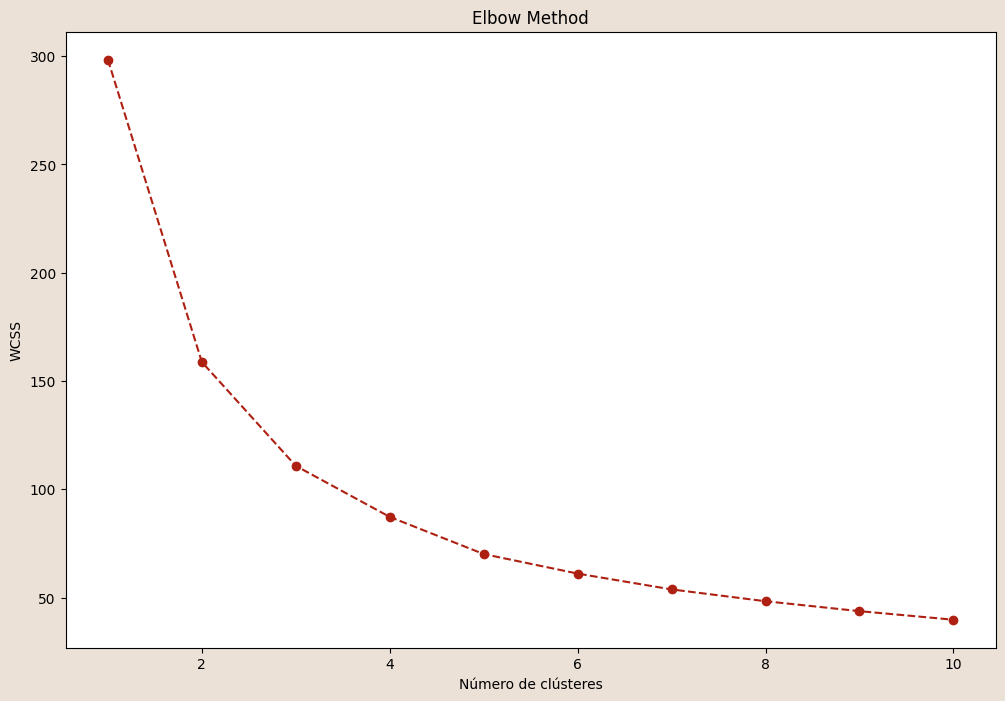

In [ ]:
wcss = []
for i in range(1, 11):  # Trying clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_copia)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 8), facecolor='#EBE1D7')
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()

#### Con PCA

In [ ]:
n_clust = 3  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clust)
cluster_labels = kmeans.fit_predict(selected_features)

# Add cluster labels to the original DataFrame
df_num_PCA = df_num.copy()
df_num_PCA['Cluster'] = cluster_labels

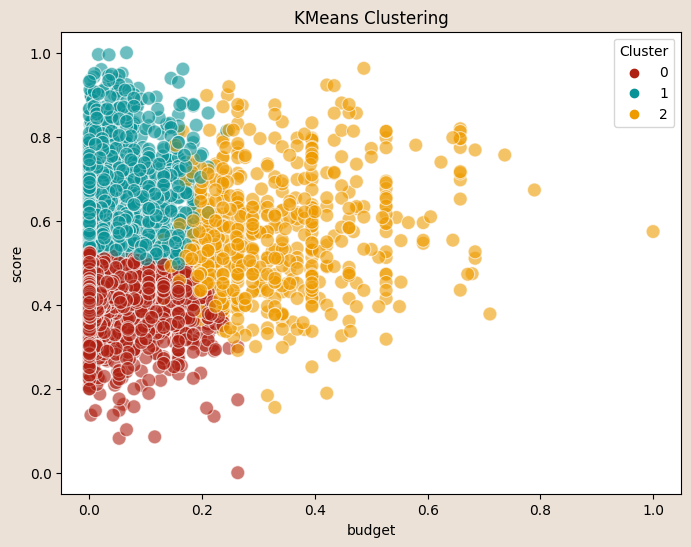

In [ ]:
#colors = sns.color_palette('husl', n_clust)

# Plotting using Seaborn
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_num_PCA, x='budget', y='score', hue='Cluster', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('budget')
plt.ylabel('score')
plt.title('KMeans Clustering')
plt.legend(title='Cluster')
plt.show()

Se llega a lo mismo.

### HDBSCAN


#### Con todas las variables

Instalamos el paquete y, luego de probar varios valores para los hiperparámetros, nos decantamos por min_cluster = 1500 para asegurarnos que se definan pocos clusters, lo que facilitaría el análisis posterior.

In [ ]:
!pip install hdbscan
import hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039179 sha256=8f76c6409b0144e55e27244b865143c6add7b497acdf568f9a87d0214f82d091
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.2
    Uninstalling Cython-3.0.2:
      Successfully uninstalled Cython-3.0.2


In [ ]:
# Planteamos los hiperparámetros y ajustamos el modelo
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=750)
cluster_labels = clusterer.fit_predict(df)

In [ ]:
# Agregamos las etiquetas de los cluster al df
df_labeled = df.copy()

df_labeled['cluster_label'] = cluster_labels

cluster_labels = df_labeled['cluster_label'].values

num_clusters = len(np.unique(cluster_labels)) - 1

noise_points = df_labeled[df_labeled['cluster_label'] == -1]

print(f'Number of Clusters: {num_clusters}')
print(f'Cluster Sizes: {df_labeled["cluster_label"].value_counts()}')

Number of Clusters: 6
Cluster Sizes: -1    30383
 1     2064
 2     1409
 0     1318
 3     1127
 4      869
 5      818
Name: cluster_label, dtype: int64


Quedan conformados 6 clusters, pero muchísimos quedan sin clasificar (30.383)

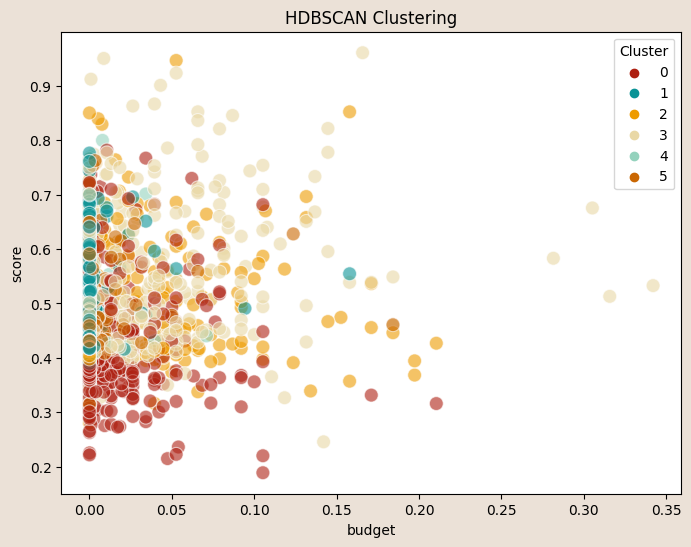

In [ ]:
df_labeled = df_labeled[df_labeled['cluster_label'] != -1]

#colors = sns.color_palette('husl', num_clusters)

# Plotting using Seaborn
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_labeled, x='budget', y='score', hue='cluster_label', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('budget')
plt.ylabel('score')
plt.title('HDBSCAN Clustering')
plt.legend(title='Cluster')
plt.show()

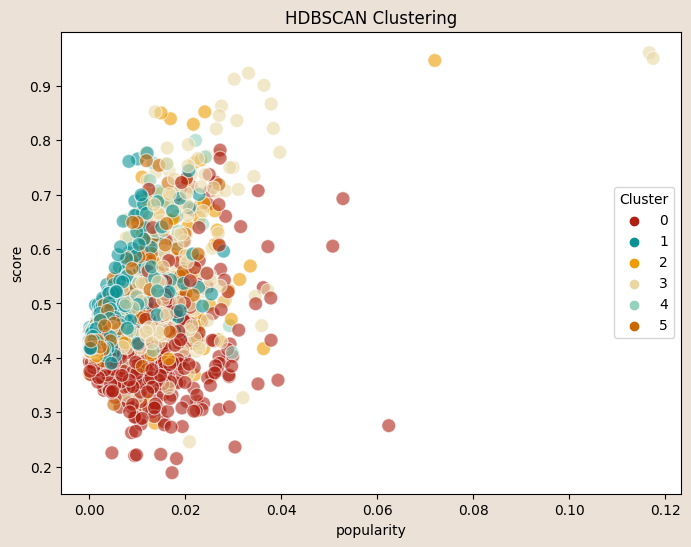

In [ ]:
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_labeled, x='popularity', y='score', hue='cluster_label', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('popularity')
plt.ylabel('score')
plt.title('HDBSCAN Clustering')
plt.legend(title='Cluster', bbox_to_anchor=(1, 0.5),loc='center right')
plt.show()

Las visualizacions con variables numéricas no nos indican que las mismas se estén usando para segregar los clusters. Vemos los géneros:

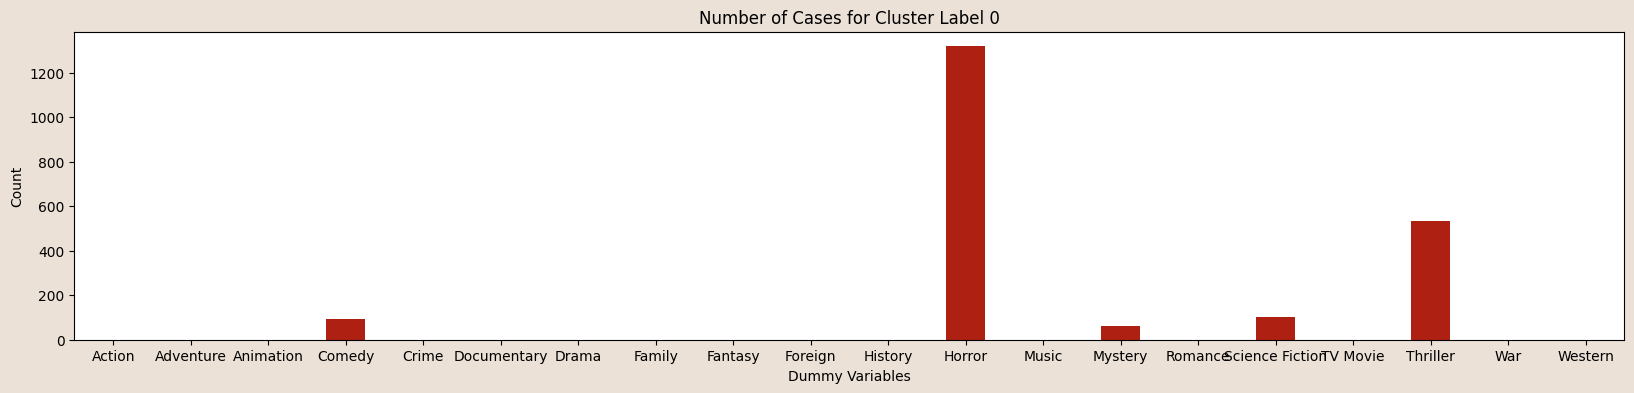

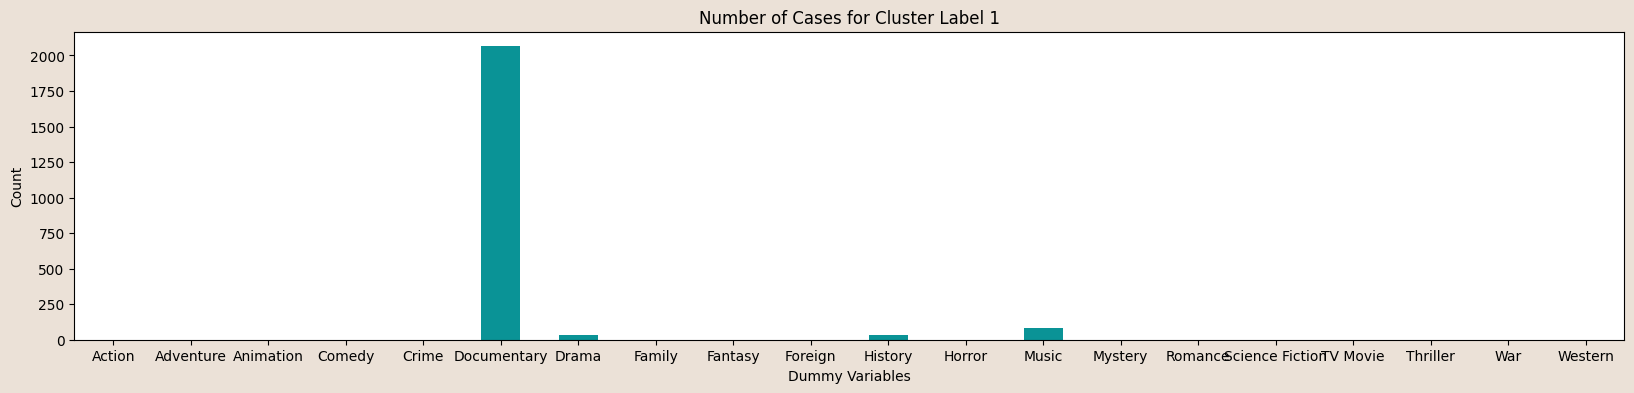

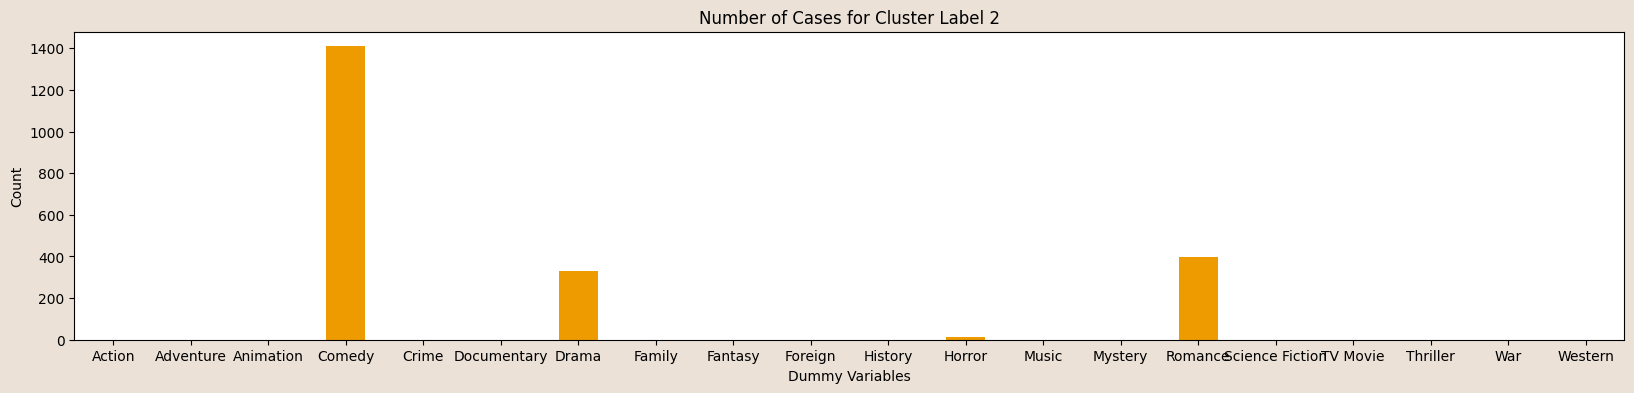

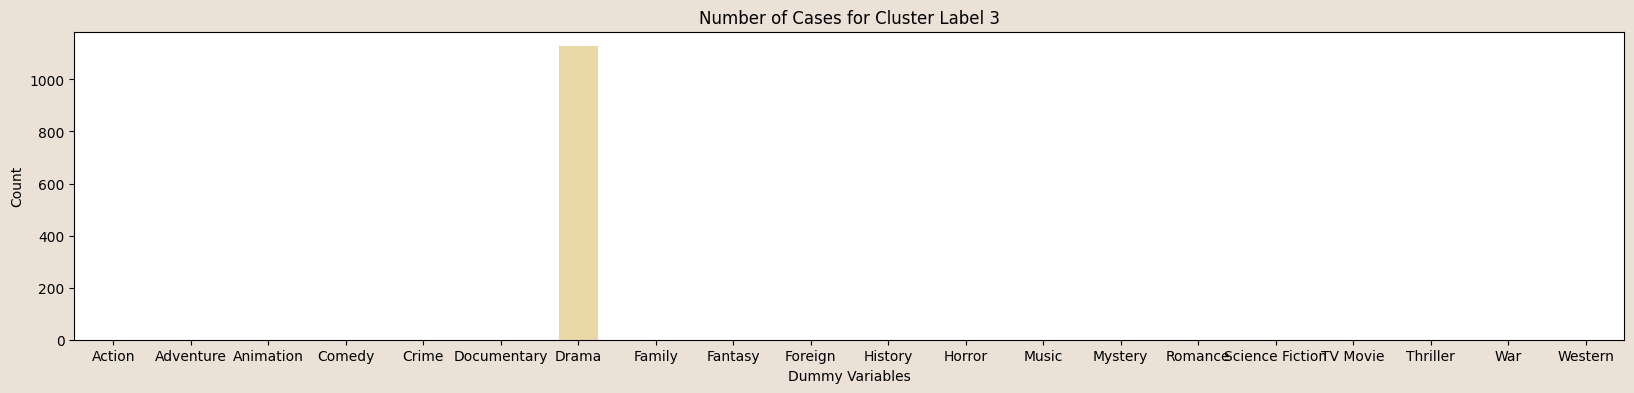

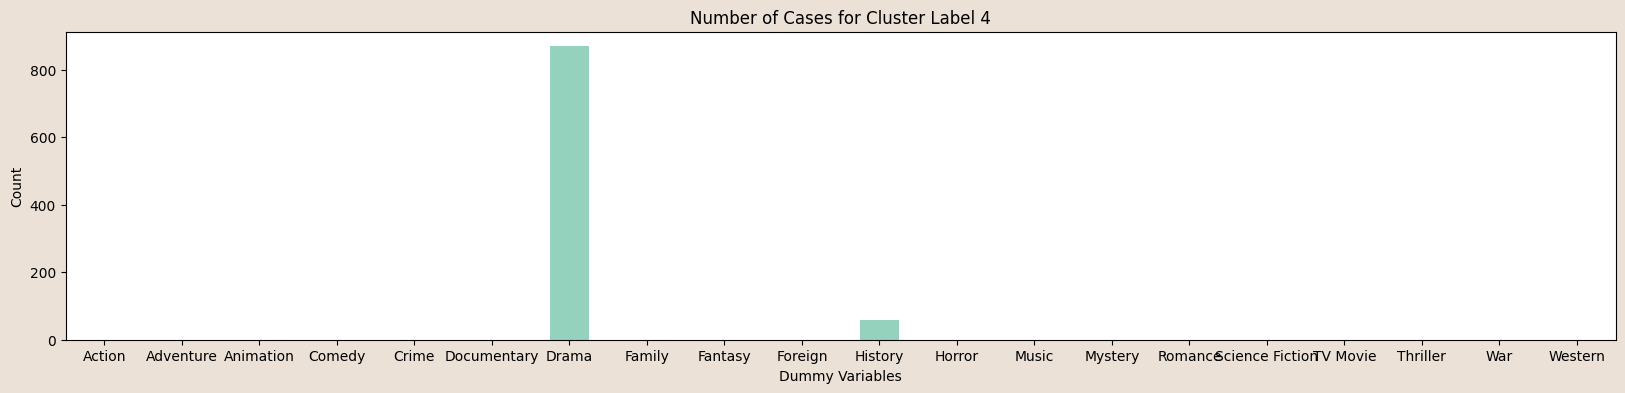

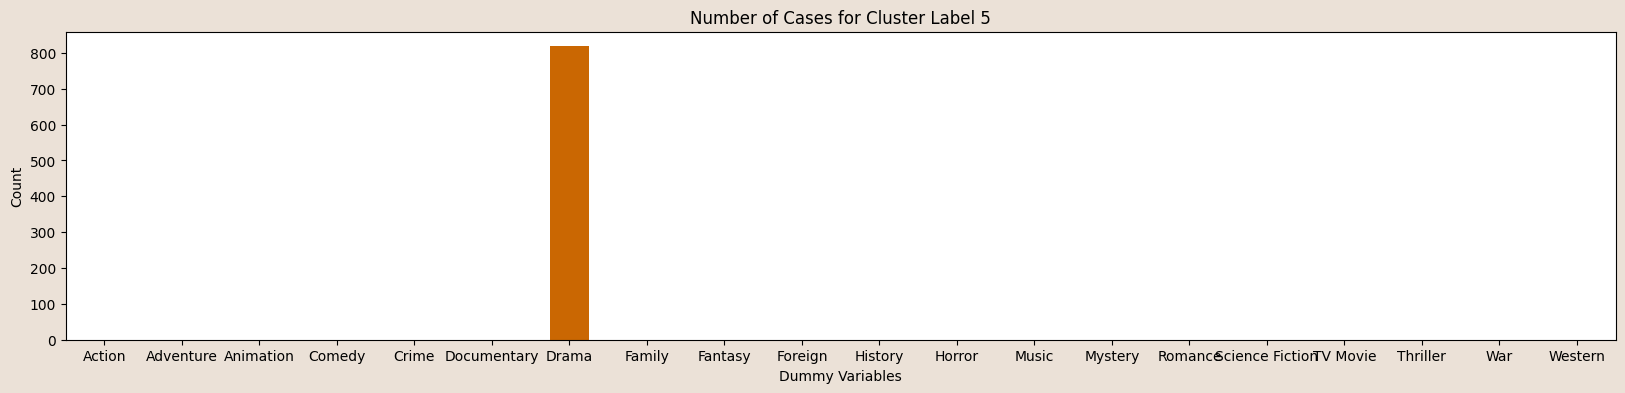

In [ ]:
for cluster_label, color in zip(range(0, num_clusters), custom_palette):
    filtered_df_labeled = df_labeled[df_labeled['cluster_label'] == cluster_label]

    # Nos aseguramos que las dummy sean floats
    for var in genres:
        filtered_df_labeled[var] = pd.to_numeric(filtered_df_labeled[var])

    # Calculamos el número de casos para cada dummy
    counts = filtered_df_labeled[genres].sum()

    # Barplot
    plt.figure(figsize=(20, 4), facecolor='#EBE1D7')
    counts.plot(kind='bar', color=color)
    plt.title(f"Number of Cases for Cluster Label {cluster_label}")
    plt.xlabel("Dummy Variables")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

Cluster 0: gran mayoría de películas de horror y, en menor medida, de thriller
Cluster 1: gran mayoría de películas documentales
Cluster 2: gran mayoría de películas de comedia, con algunas de romances y drama
Los clusters 3, 4 y 5 prácticamente sólo contienen películas de drama. Habría que analizar que distingue estos 3 clusters:

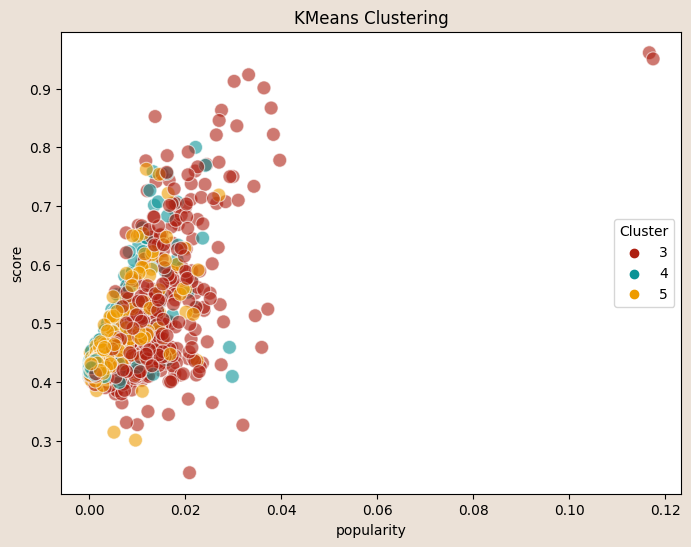

In [ ]:
df_labeled_drama = df_labeled[df_labeled['cluster_label'].isin([3,4,5])]

plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_labeled_drama, x='popularity', y='score', hue='cluster_label', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('popularity')
plt.ylabel('score')
plt.title('KMeans Clustering')
plt.legend(title='Cluster', bbox_to_anchor=(1, 0.5),loc='center right')
plt.show()

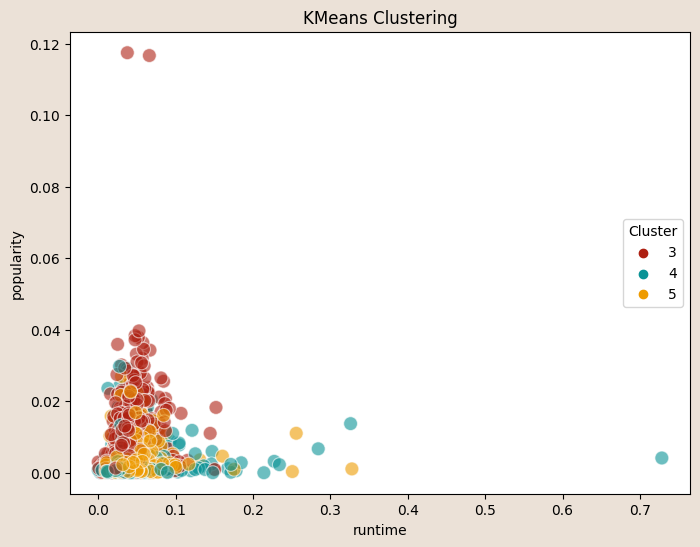

In [ ]:
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_labeled_drama, x='runtime', y='popularity', hue='cluster_label', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('runtime')
plt.ylabel('popularity')
plt.title('KMeans Clustering')
plt.legend(title='Cluster', bbox_to_anchor=(1, 0.5),loc='center right')
plt.show()

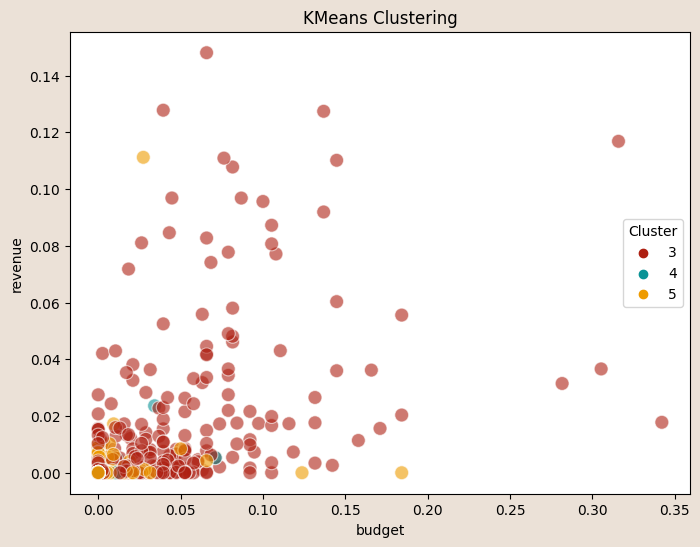

In [ ]:
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_labeled_drama, x='budget', y='revenue', hue='cluster_label', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('KMeans Clustering')
plt.legend(title='Cluster', bbox_to_anchor=(1, 0.5),loc='center right')
plt.show()

Es difícil sacar conclusiones. El cluster 3 parece agrupar películas de drama más populares

#### Con las variables numéricas

In [ ]:
# Planteamos los hiperparámetros y ajustamos el modelo
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500)
cluster_labels = clusterer.fit_predict(df_num)

In [ ]:
# Agregamos las etiquetas de los cluster al df
df_labeled = df_num.copy()

df_labeled['cluster_label'] = cluster_labels

cluster_labels = df_labeled['cluster_label'].values

num_clusters = len(np.unique(cluster_labels)) - 1

noise_points = df_labeled[df_labeled['cluster_label'] == -1]

print(f'Number of Clusters: {num_clusters}')
print(f'Cluster Sizes: {df_labeled["cluster_label"].value_counts()}')

Number of Clusters: 4
Cluster Sizes: -1    32155
 2     2069
 3     1807
 1     1289
 0      668
Name: cluster_label, dtype: int64


Se obtuvieron 4 clusters y muchas películas sin clasificar (32155). Pasamos a analizarlos. Primero con un scatter plot.

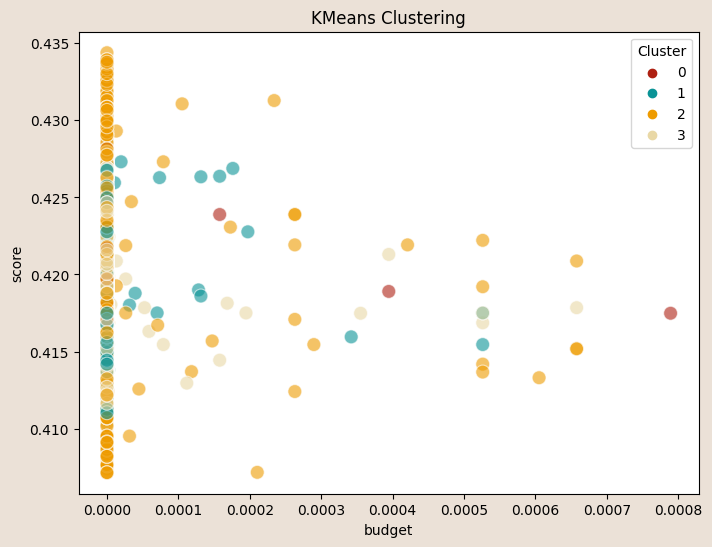

In [ ]:
df_labeled = df_labeled[df_labeled['cluster_label'] != -1]

# Plotting using Seaborn
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_labeled, x='budget', y='score', hue='cluster_label', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('budget')
plt.ylabel('score')
plt.title('KMeans Clustering')
plt.legend(title='Cluster')
plt.show()

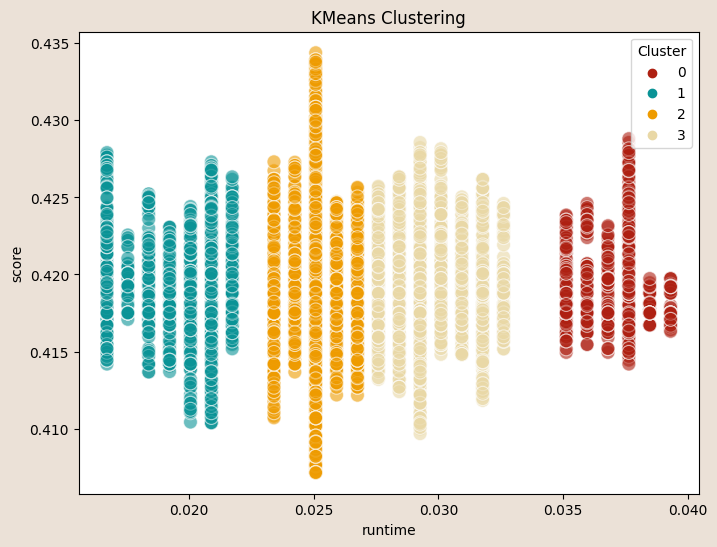

In [ ]:
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_labeled, x='runtime', y='score', hue='cluster_label', palette=custom_palette, s=100, alpha=0.6)
plt.xlabel('runtime')
plt.ylabel('score')
plt.title('KMeans Clustering')
plt.legend(title='Cluster')
plt.show()

HDBSCAN me clasifica básicamente por duración. Además dejó mucho sin clasificar.

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_labeled, x='budget', y='score', z='runtime', color='cluster_label',
                    color_continuous_scale='Jet', labels={'cluster_label': 'cluster_label'})
fig.update_layout(scene=dict(xaxis_title='budget', yaxis_title='score', zaxis_title='runtime'))
fig.show()

#### Con PCA features



In [ ]:
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=1000)
cluster_labels = clusterer.fit_predict(selected_features)

# Agregamos las etiquetas de los cluster al df
df_labeled = df.copy()
df_labeled['cluster_label'] = cluster_labels

cluster_labels = df_labeled['cluster_label'].values

num_clusters = len(np.unique(cluster_labels)) - 1

noise_points = df_labeled[df_labeled['cluster_label'] == -1]

print(f'Number of Clusters: {num_clusters}')
print(f'Cluster Sizes: {df_labeled["cluster_label"].value_counts()}')

Number of Clusters: 6
Cluster Sizes: -1    26235
 5     3833
 3     2224
 2     2097
 1     1330
 4     1222
 0     1047
Name: cluster_label, dtype: int64


Ahora se encontraron 6 clusters y quedaron menos películas sin analizar (26.235). Volvemos a analizar los gráficos de dispersión.

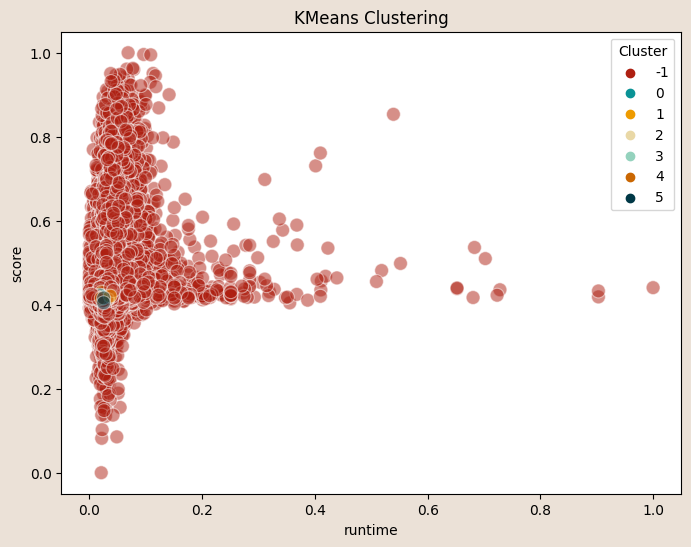

In [ ]:
plt.figure(figsize=(8, 6),facecolor='#EBE1D7')
sns.scatterplot(data=df_labeled, x='runtime', y='score', hue='cluster_label', palette=custom_palette, s=100, alpha=0.5)
plt.xlabel('runtime')
plt.ylabel('score')
plt.title('KMeans Clustering')
plt.legend(title='Cluster')
plt.show()

Los resultados son similares a aplicar HDBSCAN sobre las variables numéricas, dado que el PCA se hizo sólo considerando las variables numéricas. En ambos casos se obtuvieron clusters de películas de diferente duración.